In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

In [2]:
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

In [3]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [4]:
import os
from PIL import Image
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature
import dlib
import pandas as pd

In [5]:
# Load the CK+ dataset CSV file into a pandas DataFrame
df = pd.read_csv('ckextended.csv')

# Access the "emotion" column and convert it to a NumPy array
emotion_array = df['emotion'].values

# Assuming the "pixels" column contains strings representing pixel values separated by spaces
# Convert each string of pixels to a list of integers
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype=int))

# Convert the "pixels" column to a NumPy array
pixels_array = np.array(df['pixels'].tolist())

# Reshape the NumPy array to a 3D array with dimensions (number_of_samples, 48, 48)
pixels_array_reshaped = pixels_array.reshape((pixels_array.shape[0], 48, 48))

In [6]:
# Now, emotion_array is a NumPy array containing the values from the "emotion" column
#print(emotion_array)

In [7]:
# Now, pixels_array_reshaped is a NumPy array with shape (number_of_samples, 48, 48)
#print(pixels_array_reshaped)

In [8]:
# Initialize empty lists to store image data and labels
images = pixels_array_reshaped
labels = emotion_array

In [9]:
# Convert lists to NumPy arrays for further processing
#images = np.array(images)
#labels = np.array(labels)
#num_samples = len(images)

# Check the shapes of the arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (920, 48, 48)
Labels shape: (920,)


In [10]:
images[0].shape

(48, 48)

In [11]:
count = [0,0,0,0,0,0,0,0]
for i in range(920):
    count[labels[i]] = count[labels[i]] + 1
for i in range(8):
    print(count[i])

45
59
25
69
28
83
593
18


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [13]:
X_train = X_train/255
X_test = X_test/255

In [14]:
X_train.shape

(736, 48, 48)

In [15]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(5,5),activation='relu', input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        #tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        #tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #tf.keras.layers.Dropout(0.25),
                                        #
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(8, activation='softmax')
                                       ])

In [16]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 10, 10, 64)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 64)       256       
 ormalization)                                                   
                                                        

In [17]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001, decay=1e-6),
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint',file_name)
call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')

In [19]:
basemodel.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.2763 - accuracy: 0.6329
Epoch 1: val_accuracy improved from -inf to 0.33784, saving model to checkpoint\best_model.h5
21/21 [==============================] - 5s 129ms/step - loss: 1.2763 - accuracy: 0.6329 - val_loss: 2.0286 - val_accuracy: 0.3378
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.7689
Epoch 2: val_accuracy improved from 0.33784 to 0.35135, saving model to checkpoint\best_model.h5
21/21 [==============================] - 2s 74ms/step - loss: 0.8180 - accuracy: 0.7689 - val_loss: 2.0016 - val_accuracy: 0.3514
Epoch 3/30
20/21 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.7891
Epoch 3: val_accuracy did not improve from 0.35135
21/21 [==============================] - 2s 86ms/step - loss: 0.6747 - accuracy: 0.7885 - val_loss: 2.0349 - val_accuracy: 0.0541
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.4612 - accuracy

Epoch 30/30
20/21 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 30: val_accuracy improved from 0.89189 to 0.90541, saving model to checkpoint\best_model.h5
21/21 [==============================] - 2s 91ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4135 - val_accuracy: 0.9054


In [20]:
final_model = tf.keras.models.load_model(checkpoint_path)

In [21]:
y_pred_train = []
for i in range(736):
    y_pred = final_model.predict(tf.expand_dims(X_train[i], 0)).argmax()
    y_pred_train.append(y_pred)

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


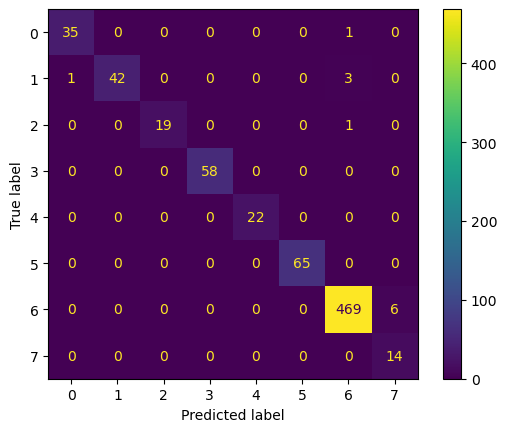

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 0.9836956521739131
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       1.00      0.91      0.95        46
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        65
           6       0.99      0.99      0.99       475
           7       0.70      1.00      0.82        14

    accuracy                           0.98       736
   macro avg       0.96      0.98      0.96       736
weighted avg       0.99      0.98      0.98       736



In [24]:
y_pred_test = []
for i in range(184):
    y_pred = final_model.predict(tf.expand_dims(X_test[i], 0)).argmax()
    y_pred_test.append(y_pred)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


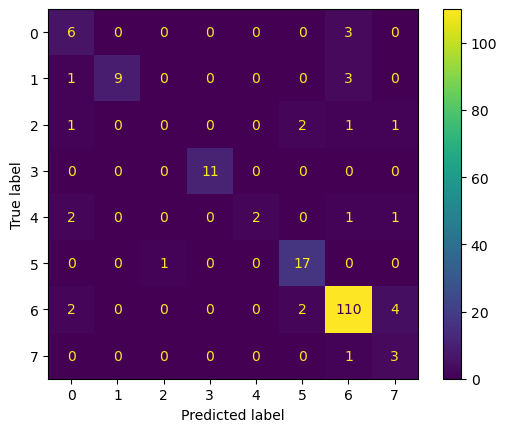

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Public Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Public Test Accuracy: 0.8586956521739131
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       1.00      0.69      0.82        13
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00        11
           4       1.00      0.33      0.50         6
           5       0.81      0.94      0.87        18
           6       0.92      0.93      0.93       118
           7       0.33      0.75      0.46         4

    accuracy                           0.86       184
   macro avg       0.70      0.66      0.64       184
weighted avg       0.87      0.86      0.85       184



In [28]:
pip install visualkeras

     ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
     ----------------------------------- -- 41.0/43.2 kB 960.0 kB/s eta 0:00:01
     -------------------------------------- 43.2/43.2 kB 423.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ValueError: Could not save to JPEG for display

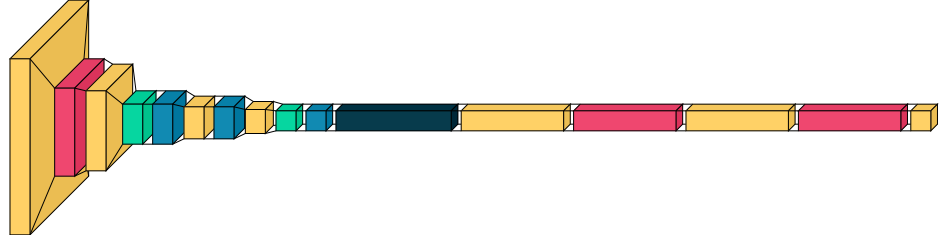

In [29]:
import visualkeras
visualkeras.layered_view(basemodel).show() # display using your system viewer
visualkeras.layered_view(basemodel, to_file='CNN_architecture.png') # write to disk
visualkeras.layered_view(basemodel, to_file='CNN_architecture.png').show() # write and show
visualkeras.layered_view(basemodel)